In [1]:
# inspect_imdb_data.py

import torch
from torchtext.datasets import IMDB
import torchtext
import random

# Disable torchtext deprecation warnings
torchtext.disable_torchtext_deprecation_warning()

def inspect_imdb_data():
    print("Loading IMDB dataset...")
    train_data = IMDB(split='train')

    # Convert to list and count overall distribution
    all_samples = list(train_data)
    total_pos = sum(1 for label, _ in all_samples if label == 2)
    total_neg = sum(1 for label, _ in all_samples if label == 1)

    print(f"\nTotal dataset statistics:")
    print(f"Total samples: {len(all_samples)}")
    print(f"Total positive reviews: {total_pos}")
    print(f"Total negative reviews: {total_neg}")

    # Randomly select 10 samples for inspection
    print("\nInspecting 10 random samples:")
    random_samples = random.sample(all_samples, 10)

    for i, sample in enumerate(random_samples, 1):
        print(f"\nSample {i}:")
        true_label, review_text = sample

        sentiment = "Negative" if true_label == 1 else "Positive"

        print(f"True Label (raw): {true_label}")
        print(f"Sentiment: {sentiment}")
        print(f"Review preview: {review_text[:200]}...")
        print("-" * 80)

    # Calculate distribution in random samples
    sample_pos = sum(1 for label, _ in random_samples if label == 2)
    sample_neg = sum(1 for label, _ in random_samples if label == 1)
    print(f"\nIn these random samples:")
    print(f"Positive reviews: {sample_pos}")
    print(f"Negative reviews: {sample_neg}")

if __name__ == "__main__":
    inspect_imdb_data()

/Users/nanzhenghan/opt/anaconda3/lib/python3.9/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/nanzhenghan/opt/anaconda3/lib/python3.9/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Loading IMDB dataset...


/Users/nanzhenghan/opt/anaconda3/lib/python3.9/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()



Total dataset statistics:
Total samples: 25000
Total positive reviews: 12500
Total negative reviews: 12500

Inspecting 10 random samples:

Sample 1:
True Label (raw): 2
Sentiment: Positive
Review preview: I have waited a long time for someone to film a faithful version of H.G. Wells' classic novel, "War Of The Worlds". Timothy Hines has finally done it! I just couldn't believe how good it was! From the...
--------------------------------------------------------------------------------

Sample 2:
True Label (raw): 1
Sentiment: Negative
Review preview: "La Furia del Hombre Lobo" forms a completely stand-alone storyline which doesn't seem to fit in at all with the previous Waldemar Daninsky movies. Some have commented that this movie is supposed to t...
--------------------------------------------------------------------------------

Sample 3:
True Label (raw): 2
Sentiment: Positive
Review preview: This was the beginning of it all! Granted, this is not Friends at its best, but this was t

In [2]:
# sentiment_analysis.py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe
from torchtext.datasets import IMDB
import nltk
from nltk.tokenize import word_tokenize
import re
import numpy as np
from tqdm import tqdm
import os
import random
import torchtext

# Disable torchtext deprecation warnings
torchtext.disable_torchtext_deprecation_warning()

def preprocess_text(text):
    """Text preprocessing function."""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Truncate or pad to fixed length of 256
    if len(tokens) > 256:
        tokens = tokens[:256]
    else:
        tokens.extend(['<pad>'] * (256 - len(tokens)))
    return tokens

def text_to_features(tokens, glove):
    """Convert tokens to GloVe embeddings."""
    features = torch.zeros(256, 300)
    for i, token in enumerate(tokens[:256]):
        if token in glove.stoi:
            features[i] = glove.vectors[glove.stoi[token]]
    return features

class IMDbDataset(Dataset):
    def __init__(self, data_iter, glove, max_samples=None, split='train'):
        """
        IMDb Dataset for sentiment analysis.

        Parameters:
            data_iter: IMDB data iterator
            glove: GloVe word vectors
            max_samples: Maximum number of samples per class (None means use all data)
            split: 'train' or 'test', used for display information
        """
        print(f"Preprocessing {split} dataset...")
        # Collect all samples and group by label
        pos_samples = []
        neg_samples = []
        all_data = list(data_iter)

        print(f"Total samples fetched for {split}: {len(all_data)}")

        print(f"Separating positive and negative samples for {split} set...")
        for label, text in all_data:
            if label == 1:  # negative
                neg_samples.append((0, text))  # Label: 0
            elif label == 2:  # positive
                pos_samples.append((1, text))  # Label: 1
            else:
                print(f"Unknown label '{label}' encountered. Skipping sample.")

        print(f"Total {split} samples - Positive: {len(pos_samples)}, Negative: {len(neg_samples)}")

        # If max_samples specified, ensure balanced classes
        if max_samples:
            samples_per_class = max_samples // 2
            # Ensure there are enough samples to sample from
            pos_samples = random.sample(pos_samples, min(len(pos_samples), samples_per_class))
            neg_samples = random.sample(neg_samples, min(len(neg_samples), samples_per_class))
            print(f"Using {len(pos_samples)} positive and {len(neg_samples)} negative samples for {split} set")

        # Combine and shuffle samples
        self.samples = []
        combined_samples = pos_samples + neg_samples
        random.shuffle(combined_samples)

        print(f"Processing {split} samples...")
        for label, text in tqdm(combined_samples, desc=f"Processing {split} samples"):
            try:
                tokens = preprocess_text(text)
                features = text_to_features(tokens, glove)
                label_tensor = torch.tensor(label, dtype=torch.long)  # Labels are already 0 or 1
                self.samples.append((features, label_tensor))
            except Exception as e:
                print(f"Error processing sample: {str(e)[:200]}")
                continue

        print(f"Successfully processed {len(self.samples)} {split} samples")

        # Verify final distribution
        final_pos = sum(1 for _, label in self.samples if label == 1)
        final_neg = sum(1 for _, label in self.samples if label == 0)
        print(f"Final {split} distribution - Positive: {final_pos}, Negative: {final_neg}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(150, 64),
            nn.ReLU(),
        )
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        # x shape: (batch_size, 256, 300)
        batch_size, seq_length, embed_dim = x.size()
        x = x.view(-1, embed_dim)  # Shape: (batch_size * 256, 300)
        token_features = self.feature_extractor(x)  # Shape: (batch_size * 256, 64)
        # Reshape back to (batch_size, 256, 64)
        token_features = token_features.view(batch_size, seq_length, -1)
        # Mean pooling over token features
        pooled_features = torch.mean(token_features, dim=1)  # Shape: (batch_size, 64)
        output = self.classifier(pooled_features)  # Shape: (batch_size, 2)
        return output

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model performance on test data."""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    pos_correct = 0
    neg_correct = 0
    pos_total = 0
    neg_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Track accuracy separately for positive and negative samples
            pos_mask = labels == 1
            neg_mask = labels == 0
            pos_correct += (predicted[pos_mask] == labels[pos_mask]).sum().item()
            neg_correct += (predicted[neg_mask] == labels[neg_mask]).sum().item()
            pos_total += pos_mask.sum().item()
            neg_total += neg_mask.sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    pos_accuracy = 100 * pos_correct / pos_total if pos_total > 0 else 0
    neg_accuracy = 100 * neg_correct / neg_total if neg_total > 0 else 0

    print('\nTest Results:')
    print(f'Loss: {test_loss:.4f}')
    print(f'Overall Accuracy: {accuracy:.2f}%')
    print(f'Positive Reviews Accuracy: {pos_accuracy:.2f}%')
    print(f'Negative Reviews Accuracy: {neg_accuracy:.2f}%')

    return accuracy

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=5):
    """Train the model."""
    model.train()
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pos_correct = 0
        neg_correct = 0
        pos_total = 0
        neg_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Track accuracy by class
            pos_mask = labels == 1
            neg_mask = labels == 0
            pos_correct += (predicted[pos_mask] == labels[pos_mask]).sum().item()
            neg_correct += (predicted[neg_mask] == labels[neg_mask]).sum().item()
            pos_total += pos_mask.sum().item()
            neg_total += neg_mask.sum().item()

            # Calculate average loss
            avg_loss = running_loss / (total // labels.size(0))
            current_acc = 100 * correct / total if total > 0 else 0

            progress_bar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })

        # Print epoch statistics
        epoch_acc = 100 * correct / total if total > 0 else 0
        print(f'\nEpoch {epoch+1}:')
        print(f'Loss: {running_loss/len(train_loader):.4f}')
        print(f'Overall Accuracy: {epoch_acc:.2f}%')
        if pos_total > 0:
            print(f'Positive Reviews Accuracy: {100*pos_correct/pos_total:.2f}%')
        else:
            print('Positive Reviews Accuracy: N/A')
        if neg_total > 0:
            print(f'Negative Reviews Accuracy: {100*neg_correct/neg_total:.2f}%')
        else:
            print('Negative Reviews Accuracy: N/A')

        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            print(f'New best accuracy: {best_accuracy:.2f}%')

def save_weights_txt(model, output_dir='weights'):
    """Save model weights in text format."""
    os.makedirs(output_dir, exist_ok=True)
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        param_numpy = param.detach().cpu().numpy()
        filename = os.path.join(output_dir, f"{name.replace('.', '_')}.txt")
        np.savetxt(filename, param_numpy.flatten(), fmt='%.8e')
        print(f"Saved {name} to {filename}")

def save_weights_binary(model, output_dir='weights_bin'):
    """Save model weights in binary format and save shape information."""
    os.makedirs(output_dir, exist_ok=True)
    state_dict = model.state_dict()
    for name, param in state_dict.items():
        param_numpy = param.detach().cpu().numpy()
        # Save shape information
        shape_filename = os.path.join(output_dir, f"{name.replace('.', '_')}_shape.txt")
        with open(shape_filename, 'w') as f:
            f.write(','.join(map(str, param_numpy.shape)))
        # Save binary data
        data_filename = os.path.join(output_dir, f"{name.replace('.', '_')}.bin")
        param_numpy.tofile(data_filename)
        print(f"Saved {name} to {data_filename} with shape {param_numpy.shape}")

def save_test_data(test_loader, output_dir='test_data_bin'):
    """
    Save test inputs and labels to binary files.

    Parameters:
        test_loader: DataLoader for test data
        output_dir: Directory to save the files
    """
    os.makedirs(output_dir, exist_ok=True)
    all_inputs = []
    all_labels = []

    print("Saving test data...")
    for inputs, labels in tqdm(test_loader, desc='Saving Test Data'):
        inputs_np = inputs.cpu().numpy()
        labels_np = labels.cpu().numpy()
        all_inputs.append(inputs_np)
        all_labels.append(labels_np)

    # Concatenate all batches
    all_inputs = np.concatenate(all_inputs, axis=0)  # Shape: (num_samples, 256, 300)
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: (num_samples,)

    # Save to binary files
    inputs_filename = os.path.join(output_dir, 'test_inputs.bin')
    labels_filename = os.path.join(output_dir, 'test_labels.bin')
    all_inputs.tofile(inputs_filename)
    all_labels.tofile(labels_filename)

    print(f"Test inputs saved to {inputs_filename}")
    print(f"Test labels saved to {labels_filename}")

def save_single_test_sample(test_loader, sample_index=0, output_dir='single_test_sample'):
    """
    Export a single test sample's input and label.

    Parameters:
        test_loader: DataLoader for test data
        sample_index: Index of the sample to export
        output_dir: Directory to save the files
    """
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for inputs, labels in test_loader:
        batch_size = inputs.size(0)
        if count + batch_size > sample_index:
            # Compute index within the current batch
            idx = sample_index - count
            single_input = inputs[idx].cpu().numpy()  # Shape: (256, 300)
            single_label = labels[idx].cpu().numpy()  # Scalar
            # Save input
            inputs_filename = os.path.join(output_dir, 'sample_input.bin')
            single_input.tofile(inputs_filename)
            # Save label
            labels_filename = os.path.join(output_dir, 'sample_label.bin')
            single_label.tofile(labels_filename)
            print(f"Saved sample {sample_index} to {output_dir}")
            return
        count += batch_size
    print("Sample index out of range.")

def main(train_samples=1000, test_samples=200):
    """
    Main function.

    Parameters:
        train_samples: Total number of training samples (split equally between positive/negative)
        test_samples: Total number of test samples (split equally between positive/negative)
    """
    # Set random seed for reproducibility
    random.seed(42)
    torch.manual_seed(42)

    # Set device (mps or CPU)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device")
    else:
        device = torch.device("cpu")
        print("Using CPU device")

    # Download NLTK data if needed
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading NLTK punkt tokenizer...")
        nltk.download('punkt', quiet=True)

    # Load datasets and word vectors
    print("Loading IMDB dataset...")
    train_data = IMDB(split='train')
    test_data = IMDB(split='test')

    print("Loading GloVe vectors...")
    glove = GloVe(name='6B', dim=300)

    # Create datasets and data loaders
    print("Creating data loaders...")
    train_dataset = IMDbDataset(train_data, glove, max_samples=train_samples, split='train')
    test_dataset = IMDbDataset(test_data, glove, max_samples=test_samples, split='test')

    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("No valid samples were processed. Exiting...")
        return

    # Adjust pin_memory based on device
    pin_memory = True if device.type == 'mps' else False

    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=0,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        pin_memory=pin_memory
    )

    # Initialize model and training components
    print("Initializing model...")
    model = SentimentModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train and evaluate
    print("Starting training...")
    try:
        train_model(model, train_loader, criterion, optimizer, device)

        print("\nEvaluating on test set...")
        test_accuracy = evaluate_model(model, test_loader, criterion, device)

    except RuntimeError as e:
        print(f"Error during training: {e}")
        print("Try reducing batch size or model size if you're running out of memory")
        return

    # Save model weights
    print("Saving model weights...")
    save_weights_txt(model)
    save_weights_binary(model)

    # Save test data for C++ implementation
    save_test_data(test_loader, output_dir='test_data_bin')

    # Save a single test sample for manual verification
    save_single_test_sample(test_loader, sample_index=0, output_dir='single_test_sample')

    print("Done!")

if __name__ == "__main__":
    # Modify these parameters to control training/test set sizes
    main(train_samples=1000, test_samples=200)

Using MPS device
Loading IMDB dataset...
Loading GloVe vectors...
Creating data loaders...
Preprocessing train dataset...
Total samples fetched for train: 25000
Separating positive and negative samples for train set...
Total train samples - Positive: 12500, Negative: 12500
Using 500 positive and 500 negative samples for train set
Processing train samples...


Processing train samples: 100%|███████████| 1000/1000 [00:00<00:00, 1058.86it/s]


Successfully processed 1000 train samples
Final train distribution - Positive: 500, Negative: 500
Preprocessing test dataset...
Total samples fetched for test: 25000
Separating positive and negative samples for test set...
Total test samples - Positive: 12500, Negative: 12500
Using 100 positive and 100 negative samples for test set
Processing test samples...


Processing test samples: 100%|███████████████| 200/200 [00:00<00:00, 920.00it/s]


Successfully processed 200 test samples
Final test distribution - Positive: 100, Negative: 100
Initializing model...
Starting training...


Epoch 1/5: 100%|█████| 125/125 [00:01<00:00, 67.28it/s, loss=0.6870, acc=54.20%]



Epoch 1:
Loss: 0.6870
Overall Accuracy: 54.20%
Positive Reviews Accuracy: 68.80%
Negative Reviews Accuracy: 39.60%
New best accuracy: 54.20%


Epoch 2/5: 100%|█████| 125/125 [00:01<00:00, 89.51it/s, loss=0.6189, acc=66.10%]



Epoch 2:
Loss: 0.6189
Overall Accuracy: 66.10%
Positive Reviews Accuracy: 61.40%
Negative Reviews Accuracy: 70.80%
New best accuracy: 66.10%


Epoch 3/5: 100%|█████| 125/125 [00:01<00:00, 92.04it/s, loss=0.4734, acc=78.20%]



Epoch 3:
Loss: 0.4734
Overall Accuracy: 78.20%
Positive Reviews Accuracy: 77.80%
Negative Reviews Accuracy: 78.60%
New best accuracy: 78.20%


Epoch 4/5: 100%|█████| 125/125 [00:01<00:00, 88.08it/s, loss=0.3896, acc=82.70%]



Epoch 4:
Loss: 0.3896
Overall Accuracy: 82.70%
Positive Reviews Accuracy: 83.60%
Negative Reviews Accuracy: 81.80%
New best accuracy: 82.70%


Epoch 5/5: 100%|█████| 125/125 [00:01<00:00, 88.35it/s, loss=0.3618, acc=84.20%]



Epoch 5:
Loss: 0.3618
Overall Accuracy: 84.20%
Positive Reviews Accuracy: 86.60%
Negative Reviews Accuracy: 81.80%
New best accuracy: 84.20%

Evaluating on test set...


Evaluating: 100%|██████████████████████████████| 25/25 [00:00<00:00, 129.27it/s]



Test Results:
Loss: 0.4226
Overall Accuracy: 82.00%
Positive Reviews Accuracy: 80.00%
Negative Reviews Accuracy: 84.00%
Saving model weights...
Saved feature_extractor.0.weight to weights/feature_extractor_0_weight.txt
Saved feature_extractor.0.bias to weights/feature_extractor_0_bias.txt
Saved feature_extractor.3.weight to weights/feature_extractor_3_weight.txt
Saved feature_extractor.3.bias to weights/feature_extractor_3_bias.txt
Saved classifier.0.weight to weights/classifier_0_weight.txt
Saved classifier.0.bias to weights/classifier_0_bias.txt
Saved classifier.3.weight to weights/classifier_3_weight.txt
Saved classifier.3.bias to weights/classifier_3_bias.txt
Saved feature_extractor.0.weight to weights_bin/feature_extractor_0_weight.bin with shape (150, 300)
Saved feature_extractor.0.bias to weights_bin/feature_extractor_0_bias.bin with shape (150,)
Saved feature_extractor.3.weight to weights_bin/feature_extractor_3_weight.bin with shape (64, 150)
Saved feature_extractor.3.bias to

Saving Test Data: 100%|███████████████████████| 25/25 [00:00<00:00, 2999.10it/s]


Test inputs saved to test_data_bin/test_inputs.bin
Test labels saved to test_data_bin/test_labels.bin
Saved sample 0 to single_test_sample
Done!


# Data Inspection

In [3]:
import numpy as np
import os
from glob import glob

def inspect_text_weights():
    """Inspect weights saved in text format"""
    print("\n=== Inspecting Text Format Weights ===")
    weights_dir = 'weights'
    if not os.path.exists(weights_dir):
        print(f"Directory not found: {weights_dir}")
        return
        
    weight_files = glob(os.path.join(weights_dir, '*.txt'))
    print(f"\nFound {len(weight_files)} weight files")
    
    for file_path in weight_files:
        layer_name = os.path.basename(file_path).replace('.txt', '')
        weights = np.loadtxt(file_path)
        print(f"\nLayer: {layer_name}")
        print(f"Shape: {weights.shape}")
        print(f"Range: [{weights.min():.4f}, {weights.max():.4f}]")
        print(f"Sample values (first 5): {weights[:5]}")

def inspect_binary_weights():
    """Inspect weights saved in binary format"""
    print("\n=== Inspecting Binary Format Weights ===")
    weights_dir = 'weights_bin'
    if not os.path.exists(weights_dir):
        print(f"Directory not found: {weights_dir}")
        return
        
    weight_files = glob(os.path.join(weights_dir, '*.bin'))
    print(f"\nFound {len(weight_files)} binary weight files")
    
    for bin_file in weight_files:
        # Get corresponding shape file
        shape_file = bin_file.replace('.bin', '_shape.txt')
        if not os.path.exists(shape_file):
            print(f"Shape file not found for: {bin_file}")
            continue
            
        # Read shape
        with open(shape_file, 'r') as f:
            shape = tuple(map(int, f.read().strip().split(',')))
            
        # Read binary data
        weights = np.fromfile(bin_file, dtype=np.float32)
        weights = weights.reshape(shape)
        
        layer_name = os.path.basename(bin_file).replace('.bin', '')
        print(f"\nLayer: {layer_name}")
        print(f"Shape: {shape}")
        print(f"Range: [{weights.min():.4f}, {weights.max():.4f}]")
        print(f"Sample values (first 5): {weights.flatten()[:5]}")

def inspect_test_data():
    """Inspect all test data saved"""
    print("\n=== Inspecting Full Test Dataset ===")
    test_dir = 'test_data_bin'
    if not os.path.exists(test_dir):
        print(f"Directory not found: {test_dir}")
        return
        
    # Load inputs
    inputs_path = os.path.join(test_dir, 'test_inputs.bin')
    if os.path.exists(inputs_path):
        # Each sample is (256, 300) shaped
        inputs = np.fromfile(inputs_path, dtype=np.float32)
        num_samples = len(inputs) // (256 * 300)
        inputs = inputs.reshape(num_samples, 256, 300)
        print("\nTest Inputs:")
        print(f"Total samples: {num_samples}")
        print(f"Data shape: {inputs.shape}")
        print(f"Range: [{inputs.min():.4f}, {inputs.max():.4f}]")
        print("First sample, first 5 words, first 5 dimensions:")
        print(inputs[0, :5, :5])
    
    # Load labels
    labels_path = os.path.join(test_dir, 'test_labels.bin')
    if os.path.exists(labels_path):
        labels = np.fromfile(labels_path, dtype=np.int64)
        print("\nTest Labels:")
        print(f"Total labels: {len(labels)}")
        print(f"Unique labels: {np.unique(labels)}")
        print(f"First 10 labels: {labels[:10]}")
        print(f"Label distribution:")
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"Label {label}: {count} samples")

def main():
    """Inspect all saved data"""
    print("Starting inspection of all saved model data...")
    
    # Check text format weights
    inspect_text_weights()
    
    # Check binary format weights
    inspect_binary_weights()
    
    # Check test data
    inspect_test_data()
    
if __name__ == "__main__":
    main()

Starting inspection of all saved model data...

=== Inspecting Text Format Weights ===

Found 8 weight files

Layer: classifier_3_weight
Shape: (64,)
Range: [-0.2875, 0.2472]
Sample values (first 5): [ 0.23999631 -0.2671552   0.12926854 -0.11112974 -0.05987721]

Layer: feature_extractor_0_bias
Shape: (150,)
Range: [-0.0858, 0.1231]
Sample values (first 5): [ 0.04023822  0.03448592 -0.03907454  0.01535335 -0.00482314]

Layer: feature_extractor_0_weight
Shape: (45000,)
Range: [-0.3149, 0.3003]
Sample values (first 5): [ 0.06101406  0.057561   -0.0851186   0.14799125 -0.00180279]

Layer: classifier_3_bias
Shape: (2,)
Range: [-0.1732, -0.0375]
Sample values (first 5): [-0.1731669  -0.03747227]

Layer: feature_extractor_3_bias
Shape: (64,)
Range: [-0.0992, 0.0864]
Sample values (first 5): [-0.03165649 -0.01386869 -0.06989487  0.08103418 -0.04148197]

Layer: feature_extractor_3_weight
Shape: (9600,)
Range: [-0.1888, 0.2280]
Sample values (first 5): [-0.02048459  0.03698495  0.13018039 -0.021

# Inference Time


Running on device: mps

Testing with batch size: 1
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.008001 ms

Testing with batch size: 8
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.000961 ms

Testing with batch size: 16
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.001217 ms

Testing with batch size: 32
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.000840 ms

Testing with batch size: 64
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.000960 ms

Testing with batch size: 128
Model is on device: mps:0
Inputs are on device: mps:0
Average inference time per sample on mps: 0.000694 ms

Running on device: cpu

Testing with batch size: 1
Model is on device: cpu
Inputs are on device: cpu
Average inference time per sample on cpu: 0.002700 ms

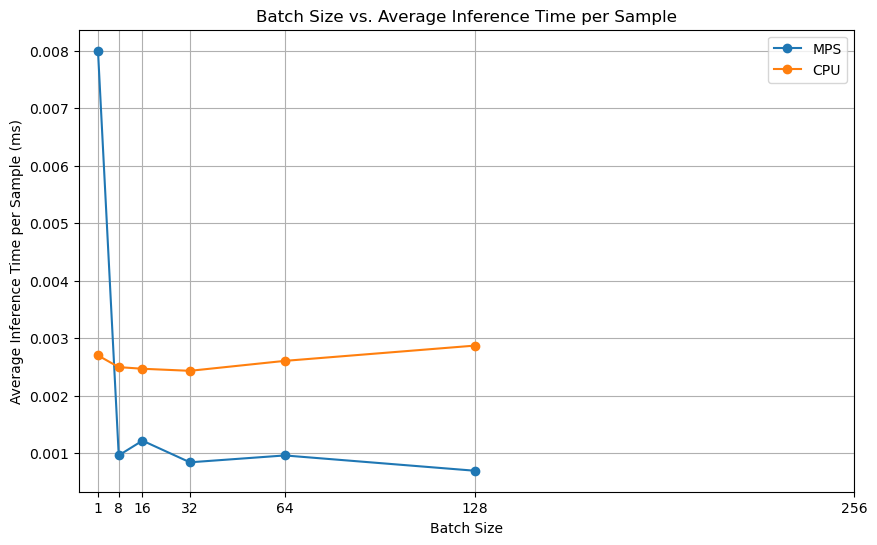

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# Define the SentimentModel (same as in your code)
class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(150, 64),
            nn.ReLU(),
        )
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        # x shape: (batch_size, 256, 300)
        batch_size, seq_length, embed_dim = x.size()
        x = x.view(-1, embed_dim)  # Shape: (batch_size * 256, 300)
        token_features = self.feature_extractor(x)  # Shape: (batch_size * 256, 64)
        # Reshape back to (batch_size, 256, 64)
        token_features = token_features.view(batch_size, seq_length, -1)
        # Mean pooling over token features
        pooled_features = torch.mean(token_features, dim=1)  # Shape: (batch_size, 64)
        output = self.classifier(pooled_features)  # Shape: (batch_size, 2)
        return output

def load_model_weights_from_bin(model, weights_dir='weights_bin'):
    """
    Load model weights from binary files saved in weights_bin directory.
    """
    state_dict = model.state_dict()
    for name in state_dict.keys():
        data_file = os.path.join(weights_dir, f"{name.replace('.', '_')}.bin")
        shape_file = os.path.join(weights_dir, f"{name.replace('.', '_')}_shape.txt")
        if not os.path.exists(data_file) or not os.path.exists(shape_file):
            print(f"Missing files for {name}, skipping.")
            continue
        with open(shape_file, 'r') as f:
            shape_str = f.read()
        shape = tuple(map(int, shape_str.strip().split(',')))
        param_numpy = np.fromfile(data_file, dtype=np.float32).reshape(shape)
        param_tensor = torch.from_numpy(param_numpy)
        state_dict[name] = param_tensor
    model.load_state_dict(state_dict)

def load_test_data(test_data_dir='test_data_bin'):
    """
    Load test inputs and labels from binary files saved in test_data_bin directory.
    """
    inputs_file = os.path.join(test_data_dir, 'test_inputs.bin')
    labels_file = os.path.join(test_data_dir, 'test_labels.bin')
    # Load inputs
    input_data = np.fromfile(inputs_file, dtype=np.float32)
    # Each sample has 256*300 floats
    sample_size = 256 * 300
    num_samples = input_data.size // sample_size
    input_data = input_data.reshape(num_samples, 256, 300)
    # Load labels
    labels_data = np.fromfile(labels_file, dtype=np.int64)
    # Convert to tensors
    inputs = torch.from_numpy(input_data)
    labels = torch.from_numpy(labels_data)
    return inputs, labels

def measure_inference_time(model, inputs, device, batch_size=8):
    """
    Measure the average inference time per sample on the specified device.
    """
    model.to(device)
    inputs = inputs.to(device)
    model.eval()

    # Verify device allocation
    print(f"Model is on device: {next(model.parameters()).device}")
    print(f"Inputs are on device: {inputs.device}")

    # Warm-up iterations
    with torch.no_grad():
        for _ in range(5):
            _ = model(inputs[:batch_size])

    # Synchronize before timing
    if device.type != 'cpu':
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()

    # Measure inference time
    total_time = 0.0
    total_samples = 0
    iterations = 20  # Increase for better averaging
    with torch.no_grad():
        for _ in range(iterations):
            start_time = time.perf_counter()
            _ = model(inputs)
            if device.type != 'cpu':
                torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
            end_time = time.perf_counter()
            inference_time = end_time - start_time
            total_time += inference_time
            total_samples += inputs.size(0)

    avg_time_per_sample = total_time / (iterations * total_samples)
    avg_time_per_sample_ms = avg_time_per_sample * 1e3  # Convert to milliseconds
    print(f"Average inference time per sample on {device}: {avg_time_per_sample_ms:.6f} ms")
    return avg_time_per_sample_ms

def main():
    # Initialize model
    model = SentimentModel()
    # Load model weights
    load_model_weights_from_bin(model, weights_dir='weights_bin')
    # Load test data
    inputs, _ = load_test_data(test_data_dir='test_data_bin')  # Labels are not needed for inference speed

    # Prepare devices list
    devices = []
    if torch.backends.mps.is_available():
        devices.append(torch.device('mps'))
    devices.append(torch.device('cpu'))

    # Test with various batch sizes
    batch_sizes = [1, 8, 16, 32, 64, 128, 256]


    # Dictionary to store results
    results = {str(device): {'batch_sizes': [], 'times': []} for device in devices}

    for device in devices:
        print(f"\nRunning on device: {device}")
        for batch_size in batch_sizes:
            if batch_size > inputs.size(0):
                continue  # Skip if batch size is larger than dataset
            print(f"\nTesting with batch size: {batch_size}")
            # Create batched inputs
            batched_inputs = inputs[:(inputs.size(0) // batch_size) * batch_size]
            avg_time_per_sample = measure_inference_time(model, batched_inputs, device, batch_size=batch_size)
            results[str(device)]['batch_sizes'].append(batch_size)
            results[str(device)]['times'].append(avg_time_per_sample)

    # Visualization
    plt.figure(figsize=(10, 6))
    for device in devices:
        plt.plot(results[str(device)]['batch_sizes'], results[str(device)]['times'],
                 marker='o', label=str(device).upper())

    plt.title('Batch Size vs. Average Inference Time per Sample')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Inference Time per Sample (ms)')
    plt.legend()
    plt.grid(True)
    plt.xticks(batch_sizes)
    plt.show()

if __name__ == '__main__':
    main()
